# Real estate price estimator

This code implements a model to estimate the real estate prices of old apartments in Paris. The model takes a geographical coordination and returns an estimate of the price per square meter.

In [21]:
import pandas as pd
import numpy as np
import shapefile
from matplotlib import pyplot as plt
from tqdm import tqdm
import json

### Load datasets to appropriate formats

`shapefile` can load and interpret zipped [shapefile data](https://en.wikipedia.org/wiki/Shapefile)

In [2]:
# guessing file types is memory demanding, low_memory=False avoids warning
# https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

transactions_df = pd.read_csv('../data/valeursfoncieres-2020.csv', sep=',', low_memory=False)
locations_sf = shapefile.Reader('../data/cadastre-75-parcelles-shp.zip')

### Transform and filter data

The shapefile data contains a record database, from which the department codes, the commune codes, section codes and plan number codes can be extracted. This data can also be found in the database of transactions and is used for filtering and searching.

Sets of each parameter are created from the shapefile data (77720 entries) to pre-filter the transaction data (3484957 entries). This already reduces the transaction dataset by a factor of 100 (34815 entries)

In [3]:
#Remove all datapoints where there is no financial information
transactions_df = transactions_df[~np.isnan(transactions_df['Valeur fonciere'])]

sf_departm_set = set()
sf_commune_set = set()
sf_section_set = set()
sf_no_plan_set = set()

for record in locations_sf.records():
    sf_departm_set.add(str(int(record[1]) // 1000))
    sf_commune_set.add(int(record[1]) %  1000)
    sf_section_set.add(record[3])
    sf_no_plan_set.add(int(record[4]))
    
# pre-filter dataset
pre_filtered_df = transactions_df[(transactions_df['Code departement'].isin(sf_departm_set)) & \
                                  (transactions_df['Code commune'].isin(sf_commune_set)) & \
                                  (transactions_df['Section'].isin(sf_section_set)) & \
                                  (transactions_df['No plan'].isin(sf_no_plan_set)) & \
                                  (transactions_df['Code type local'].isin({1.0, 2.0})) \
                                 ]

From the pre-filtered data, again sets of the commune codes, section codes and plan number codes are created. These sets are used to filter iterations through the shapefile records. There is only one department code in paris, so no filtering is needed here.

In [4]:
#df_commune_set = set()
df_section_set = set()
df_no_plan_set = set()

for departm, commune, section, no_plan in zip(pre_filtered_df['Code departement'],
                                                 pre_filtered_df['Code commune'], \
                                                 pre_filtered_df['Section'], \
                                                 pre_filtered_df['No plan']):
    #df_commune_set.add(commune)
    df_section_set.add(section)
    df_no_plan_set.add(no_plan)

Search for related rows in locations database and transactions database. Link the two in new dataframe.

The shapefile contains geo-data of each parcel in question, saved as a list of points which define the outline of the parcel. To define a center point for the parcel, the arithmetic mean of the border is calculated. It is assumed that most parcels follow mostly convex, simple shapes (no rings, no harsh L or U forms).

In [5]:
filtered_df = pd.DataFrame(columns=['LocationID', 'Cost', 'Area', 'CostPerArea', 'PosX', 'PosY'])

multi_transaction_list = []

for rec in tqdm(locations_sf.records()):
    if int(rec['numero']) in df_no_plan_set: # plan number entries have greatest difference between the two datasets, best filter
        if rec['section'] in df_section_set: # section has second greatest difference
            # department code and commune code are consolidated in single dataframe, separated by division and modulo
            filtered_transaction = pre_filtered_df[(pre_filtered_df['Code departement'] == str(int(rec[1]) // 1000)) & \
                                                   (pre_filtered_df['Code commune'] == int(rec[1]) % 1000) & \
                                                   (pre_filtered_df['Section'] == rec[3]) & \
                                                   (pre_filtered_df['No plan'] == int(rec[4])) \
                                                  ]
            
            if len(filtered_transaction) > 0:
            
                location_id = rec.oid
                # if multiple transactions are found under the same code, I used the most expensive one
                total_cost_all_transactions = np.max(filtered_transaction['Valeur fonciere'].to_numpy())
                area = rec['contenance']
                cost_per_area = total_cost_all_transactions / area
                
                #calculate average (center) of shape to get a geo location
                points = np.array([[point[0], point[1]] for point in locations_sf.shape(location_id).points])
                
                avg_x = np.sum(points[:,0]) / points.shape[0]
                avg_y = np.sum(points[:,1]) / points.shape[0]
                
                data_entry = pd.DataFrame({'LocationID':[location_id],
                                           'Cost':[total_cost_all_transactions],
                                           'Area':[area],
                                           'CostPerArea':[cost_per_area],
                                           'PosX':[avg_x],
                                           'PosY':[avg_y]})
            
                filtered_df = pd.concat([filtered_df, data_entry])
                
            if len(filtered_transaction) > 2:
                multi_transaction_entry = {}
                multi_transaction_entry['id'] = rec.oid
                multi_transaction_entry['data'] = filtered_transaction
                
                multi_transaction_list.append(multi_transaction_entry)

100%|████████████████████████████████████| 77720/77720 [03:30<00:00, 369.92it/s]


Sometimes, the resulting filtered transaction is a list of multiple transactions happening on the same parcel. To account for this, the most expensive transaction of this parcel is chosen.

In [6]:
with pd.option_context('display.max_columns', None):
    display(multi_transaction_list[0]['data'])

,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
3456459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,06/01/2020,Vente,279000.0,273.0,NaN,RUE,9624,DE VAUGIRARD,75015.0,PARIS 15,75,115,NaN,AB,29,NaN,301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,NaN,24.0,1.0,NaN,NaN,NaN
3456512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,13/01/2020,Vente,229000.0,273.0,NaN,RUE,9624,DE VAUGIRARD,75015.0,PARIS 15,75,115,NaN,AB,29,NaN,306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,NaN,18.0,1.0,NaN,NaN,NaN
3457875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,15/04/2020,Vente,500000.0,273.0,NaN,RUE,9624,DE VAUGIRARD,75015.0,PARIS 15,75,115,NaN,AB,29,NaN,18,NaN,309,45.0,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,NaN,45.0,2.0,NaN,NaN,NaN
3458706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29/06/2020,Vente,490000.0,273.0,NaN,RUE,9624,DE VAUGIRARD,75015.0,PARIS 15,75,115,NaN,AB,29,NaN,151,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,NaN,48.0,2.0,NaN,NaN,NaN


The resulting dataset is filtered by removing outliers. With the geometric points and the cost per area, a scatter plot is used to do some quick visual sanitation of the resulting data.

The scattered points result in a representative map of paris, where the Seine river, Champ de Mars and other parks/landmarks can clearly be made out. In addition, the filtered price per area shows a trend of more expensive apartments in the center of the city, which agrees with common conception of city apartment prices.

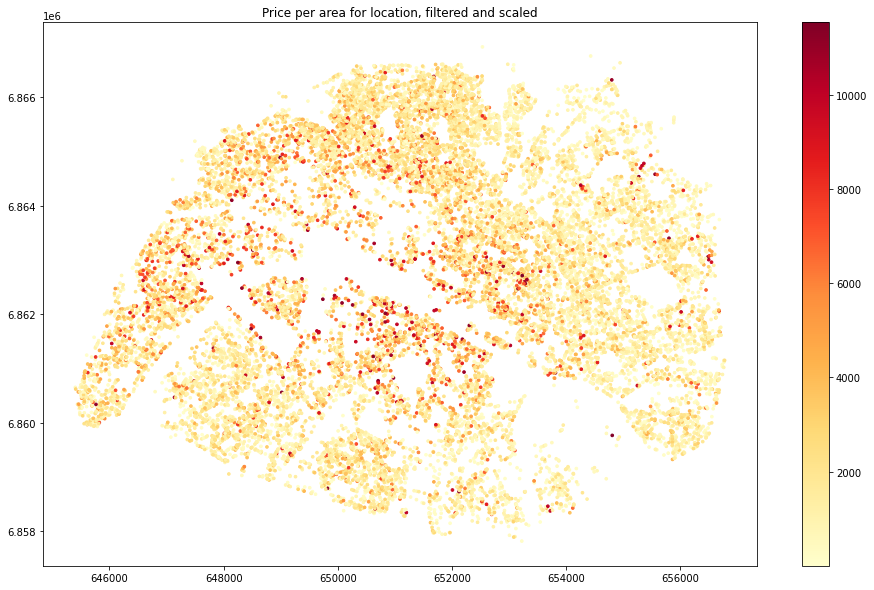

In [7]:
# remove outliers in dataset
median = filtered_df['CostPerArea'].median()
std   = filtered_df['CostPerArea'].std()

smoothed_df = filtered_df[(filtered_df['CostPerArea'] <= median + (std))]

posx = smoothed_df['PosX'].to_numpy(dtype=float)
posy = smoothed_df['PosY'].to_numpy(dtype=float)
cpa = smoothed_df['CostPerArea'].to_numpy(dtype=float)

plt.figure(figsize=(16, 10))
plt.title('Price per area for location, filtered and scaled')
plt.scatter(posx, posy, c=cpa, cmap='YlOrRd', s=7)
plt.colorbar()
plt.show();

### Save data

In [8]:
filtered_df.to_csv('../data/cost_location_data.csv')

### Train model

In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skmetrics

filtered_df = pd.read_csv('../data/cost_location_data.csv')

# data for model
X1 = filtered_df['PosX'].to_numpy(dtype=float)
X2 = filtered_df['PosY'].to_numpy(dtype=float)
y = filtered_df['CostPerArea'].to_numpy(dtype=float)

X = np.hstack([X1[..., np.newaxis], X2[..., np.newaxis]])

train_fraction = 0.8
train_test_index = int(X.shape[0] * 0.8)

X_train = X[:train_test_index]
X_test = X[train_test_index:]

y_train = y[:train_test_index]
y_test = y[train_test_index:]

model = KNeighborsRegressor(weights='distance')

parameters = {'n_neighbors':range(1,100)}

gs_model = GridSearchCV(model,
                        param_grid=parameters,
                        n_jobs=1,
                        scoring='neg_median_absolute_error')
                        
gs_model.fit(X_train, y_train)

# save model data
with open('../data/model_params.json', 'w') as outfile:
    json.dump(gs_model.best_params_, outfile)

test_error = skmetrics.median_absolute_error(y_test, gs_model.predict(X_test))

print('Fitting done. Best value for k:', gs_model.best_params_)
print('Median absolute error on test set:', test_error)

Fitting done. Best value for k: {'n_neighbors': 10}
Median absolute error on test set: 917.7320130350886


### Estimate price of locaction with model

In [ ]:
with open('../data/model_params.json', 'r') as infile:
    model_params = json.load(infile)

data = pd.read_csv('../data/cost_location_data.csv')

X1 = data['PosX'].to_numpy(dtype=float)
X2 = data['PosY'].to_numpy(dtype=float)
y = data['CostPerArea'].to_numpy(dtype=float)

X = np.hstack([X1[..., np.newaxis], X2[..., np.newaxis]])

model = KNeighborsRegressor(n_neighbors=model_params['n_neighbors'])
model.fit(X, y)

x_min = np.min(X[:,0])
x_max = np.max(X[:,0])
y_min = np.min(X[:,1])
y_max = np.max(X[:,1])

x_coord = input('Enter x-coordinate (accepted range [{}-{}]):\n'.format(x_min, x_max))
y_coord = input('Enter y-coordinate (accepted range [{}-{}]):\n'.format(y_min, y_max))

x_coord = float(x_coord)
y_coord = float(y_coord)

if x_min <= x_coord <= x_max and y_min <= y_coord <= y_max:

    prediction = model.predict([[x_coord, y_coord]])
    print('Predicted price per area for chosen coordinates:', prediction)

else:
    print("Entered coordinates not between range.")